In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import datetime
import cftime

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
ds_soil = xr.open_dataset('/home/wpratt3/Clim680/Data/soilw.mon.mean.v2.nc.1')
ds_climo = ds_soil.groupby('time.month').mean()
ds_anoms = ds_soil.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset> Size: 956MB
Dimensions:  (lat: 360, lon: 720, time: 922)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-10-01
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    soilw    (time, lat, lon) float32 956MB nan nan nan ... 119.5 119.7 119.6

In [36]:
file_ao = '/home/wpratt3/Clim680/Assignment3/ao_index.txt'
df_ao = pd.read_csv(file_ao)
#df_ao_year = df_ao[(df_ao['Year'] >= 1991) & (df_ao['Year'] <= 2020)]
df_ao['time'] = df_ao.apply(lambda x: cftime.DatetimeGregorian(x['Year'], x['Month'], 1), axis=1)
df_ao_index = df_ao.set_index('time')
da_ao = df_ao_index.to_xarray()
da_ao


<xarray.Dataset> Size: 29kB
Dimensions:  (time: 898)
Coordinates:
  * time     (time) object 7kB 1950-01-01 00:00:00 ... 2024-10-01 00:00:00
Data variables:
    Year     (time) int64 7kB 1950 1950 1950 1950 1950 ... 2024 2024 2024 2024
    Month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
    Value    (time) float64 7kB -0.0603 0.6268 -0.0081 ... 1.284 -0.6237 0.5248

In [44]:
#Categorize the arctic oscillation by month
positive = da_ao.where(da_ao['Value'] >= 1)
negative = da_ao.where(da_ao['Value'] <= -1)
neutral = da_ao.where((da_ao['Value'] >= -1) & (da_ao['Value'] <= 1))

positive_counts = positive.count(dim='time').values()
negative_counts = negative.count(dim='time').values
neutral_counts = neutral.count(dim='time').values

counts= [positive_counts,
        negative_counts,
        neutral_counts]

ValuesView(<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    Year     int64 8B 103
    Month    int64 8B 103
    Value    int64 8B 103)

In [43]:
positive_no_null = positive.dropna(dim='time')
negative_no_null = negative.dropna(dim='time')
neutral_no_null = neutral.dropna(dim='time')

positive_no_null

#positive_soil_sel = ds_anoms.sel(time=positive_no_null[dim='time'])
#negative_soil_sel = ds_anoms.sel(time=negative_no_null['time'])
#neutral_soil_sel = ds_anoms.sel(time=neutral_no_null['time'])

#positive_soil = positive_soil_sel.mean(dim='time')
#negative_soil = negative_soil_sel.mean(dim='time')
#neutral_soil = neutral_soil_sel.mean(dim='time')

#comp_soil = [positive_soil, negative_soil, neutral_soil]
#comp_soil

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 103)
Coordinates:
  * time     (time) object 824B 1951-12-01 00:00:00 ... 2024-08-01 00:00:00
Data variables:
    Year     (time) float64 824B 1.951e+03 1.953e+03 ... 2.023e+03 2.024e+03
    Month    (time) float64 824B 12.0 3.0 5.0 10.0 1.0 ... 5.0 10.0 2.0 5.0 8.0
    Value    (time) float64 824B 1.987 1.068 1.391 1.139 ... 1.6 1.134 1.284

NameError: name 'comp_soil' is not defined

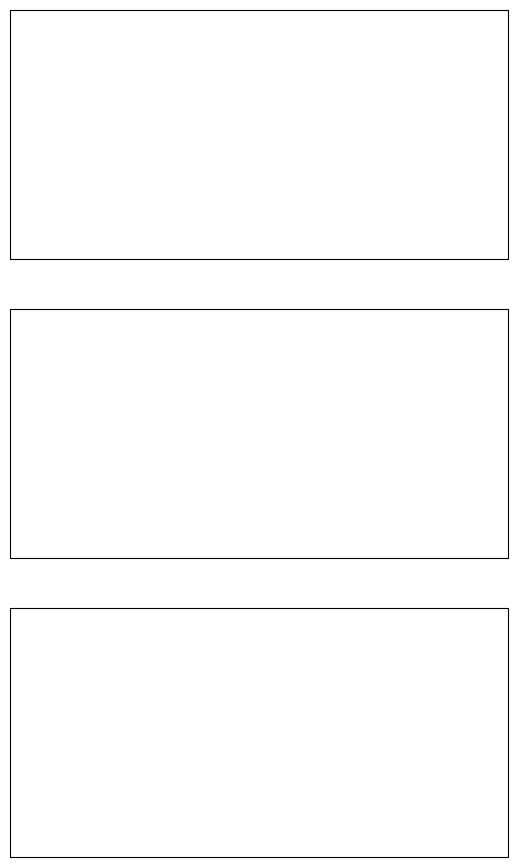

In [ ]:
labels=['Positive','Negative', 'Neutral']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,ao in enumerate(comp_soil):

        # Select the season
        data = comp_soil[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_soil[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_soil[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies during Arctic Oscillation') 

In [ ]:
diff_soil =[positive_soil-neutral_soil, 
             negative_soil-neutral_soil]

In [ ]:
labels=['Positive-Neutral','Negative-Neutral']
clevs=np.arange(-3,3.5,0.5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,ao in enumerate(diff_soil):

        # Select the season
        data = diff_soil[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=diff_precip[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons,diff_precip[i]['lat'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Differences during Arctic Oscillation')

In [ ]:
p = 0.05

positive_soil_vals = ds_anoms.sel(time=Positive.dropna(dim='time')['time'])
negative_soil_vals = ds_anoms.sel(time=Negative.dropna(dim='time')['time'])
neutral_soil_vals = ds_anoms.sel(time=Neutral.dropna(dim='time')['time'])

tstat,pval = ttest_ind(positive_soil_vals, 
                neutral_soil_vals, 
                equal_var = False)

mask_diff = diff_soil[0].where(pval <= p)

In [ ]:
labels=['Positive vs. Neutral']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]

# Define the figure and each axis for the 2 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})


data=diff_soil[0]

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_precip[0]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_precip[0]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_precip[0]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='BrBG',extend='both')

# Overlay of stippling
ss=axs.contourf(lons,diff_precip[0]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['///',''],extend='both',alpha=0.0)

# Draw the coastines for each subplot
axs.coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Differences Positive-Neutral')